# Combine aerosol forcings

Here we show that our relationship handles non-linearity in ERFaci, by the fact that co-varying all three species gives the ERFaci of -0.84, whereas the sum of the ERFaci in notebooks 2-4 is -0.97.

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import matplotlib.pyplot as pl
import pandas as pd
import pooch
import numpy as np

/Users/c.l.b.alexander/Documents/FAIR/fair_virtual_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [3]:
climate_response_df

,model,run,gamma,C1,C2,C3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,F_4xCO2
0,UKESM1-0-LL,r1i1p1f2,3.548407,2.9173,11.283175,73.248724,0.655766,2.597878,0.612934,1.133709,0.497439,0.439134,7.378788


In [4]:
aerosol_df = pd.read_csv('../data/smith2023/ukesm_ghan2013_aerosol_forcing.csv', index_col=0)

In [5]:
erfari = aerosol_df['ERFari']

In [6]:
erfaci = aerosol_df['ERFaci']

In [7]:
f = FAIR()

In [8]:
scenarios = ['ssp245']
configs = ['UKESM1-0-LL']
species = ['BC', 'OC', 'Sulfur', 'Aerosol-radiation interactions', 'Aerosol-cloud interactions']

In [9]:
f.define_time(1850, 2015, 1)
f.define_scenarios(scenarios)
f.define_configs(configs)
f.define_species(*read_properties(filename='../data/species_configs_properties_vanilla.csv', species=species))

In [10]:
f.allocate()

In [11]:
f.fill_from_rcmip()

In [12]:
fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])

In [13]:
initialise(f.forcing, 0)
initialise(f.temperature, 0)

In [14]:
f.fill_species_configs(filename='../data/species_configs_properties_vanilla.csv')

In [15]:
f.species_configs

<xarray.Dataset> Size: 2kB
Dimensions:                                   (config: 1, specie: 5, gasbox: 4)
Coordinates:
  * config                                    (config) <U11 44B 'UKESM1-0-LL'
  * specie                                    (specie) <U30 600B 'BC' ... 'Ae...
  * gasbox                                    (gasbox) int64 32B 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 40B 0....
    forcing_efficacy                          (config, specie) float64 40B 1....
    forcing_temperature_feedback              (config, specie) float64 40B 0....
    forcing_scale                             (config, specie) float64 40B 1....
    partition_fraction                        (config, specie, gasbox) float64 160B ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 160B ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 40B 0....
    cl_atoms                                  (specie) float64 40B nan ... nan
    br_atoms                                  (specie) float64 40B nan ... nan
    fractional_release                        (config, specie) float64 40B na...
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 40B 0....
    lifetime_temperature_sensitivity          (config) float64 8B 0.0

In [16]:
rcmip_emissions_file = pooch.retrieve(
    url="doi:10.5281/zenodo.4589756/rcmip-emissions-annual-means-v5-1-0.csv",
    known_hash="md5:4044106f55ca65b094670e7577eaf9b3",
)
emis_df = pd.read_csv(rcmip_emissions_file)

In [17]:
bc = emis_df.loc[(emis_df['Scenario']=='historical')&(emis_df['Variable']=='Emissions|BC')&(emis_df['Region']=='World'),'1750':'2014'].values.squeeze()
oc = emis_df.loc[(emis_df['Scenario']=='historical')&(emis_df['Variable']=='Emissions|OC')&(emis_df['Region']=='World'),'1750':'2014'].values.squeeze()
so2 = emis_df.loc[(emis_df['Scenario']=='historical')&(emis_df['Variable']=='Emissions|Sulfur')&(emis_df['Region']=='World'),'1750':'2014'].values.squeeze()

In [18]:
# 1850 baselines
f.species_configs['baseline_emissions'].loc[dict(specie='Sulfur')] = 4.5444637755469
f.species_configs['baseline_emissions'].loc[dict(specie='BC')] = 2.57112447874271
f.species_configs['baseline_emissions'].loc[dict(specie='OC')] = 18.2268247866406

In [19]:
# aerosol radiation response - from notebook 05
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00283793
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.01757433
f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.0028512

# aerosol cloud response - from notebook 05
f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -8.22336281e-01
f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 3.01888722e-02
f.species_configs['aci_shape'].loc[dict(specie='BC')] = 5.07111186e-30
f.species_configs['aci_shape'].loc[dict(specie='OC')] = 6.60381587e-16

In [20]:
# UKESM calibrations
f.species_configs['aci_scale']

<xarray.DataArray 'aci_scale' (config: 1)> Size: 8B
array([-0.82233628])
Coordinates:
  * config   (config) <U11 44B 'UKESM1-0-LL'

In [21]:
f.run()

Running 1 projections in parallel: 100%|██████████| 165/165 [00:00<00:00, 13941.86timesteps/s]


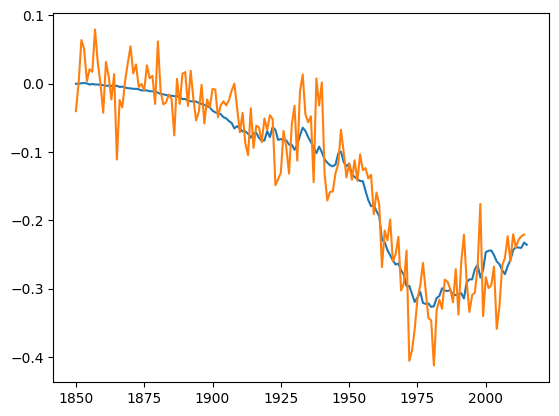

In [22]:
pl.plot(f.timebounds, f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')])
pl.plot(erfari)

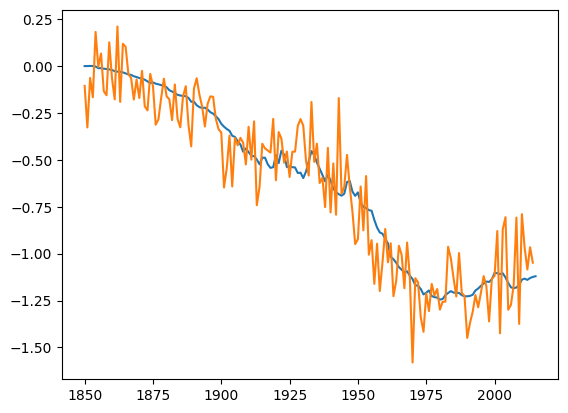

In [23]:
pl.plot(f.timebounds, f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')])
pl.plot(erfaci)

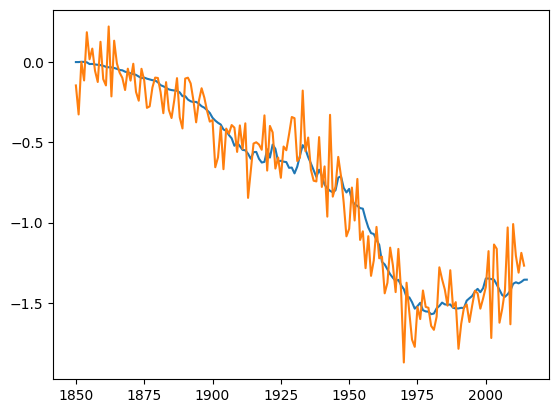

In [24]:
pl.plot(f.timebounds, f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')] + f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')])
pl.plot(erfari+erfaci)

In [25]:
# Target -0.25
f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1]

np.float64(-0.23567722205377134)

In [26]:
# Target -0.99: is this off because we're comparing single year forcing?
f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1]

np.float64(-1.1204297578924667)

In [27]:
# Target -1.09: is this off because we're comparing single year forcing?
(
    f.forcing.loc[dict(specie='Aerosol-cloud interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1] +
    f.forcing.loc[dict(specie='Aerosol-radiation interactions', config='UKESM1-0-LL', scenario='ssp245')].values[-1]
)

np.float64(-1.356106979946238)